In [1]:
import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from IPython.display import display

import seaborn as sns
plt.style.use('ggplot')

In [12]:
bkkpm_combo = pd.read_csv('data/model/bkkpm_combo_fireAR.csv')
bkkpm_combo.rename(columns={'Unnamed: 0':'datetime'},inplace=True)
bkkpm_combo['datetime'] = pd.to_datetime(bkkpm_combo['datetime'])
bkkpm_combo.head()

,datetime,PM2.5,is_holiday,is_weekend,DayofWeek,weekofyear,hour,prev_level,Wind,Temperature(C),Humidity(%),Wind Speed(kmh),is_rain,fire0-240km,fire240km-480km,fire480km-720km,index
0,2016-03-04 16:00:00,35,0,0,4,9,16,44,SSW,33.89,46.0,14.48,0.0,1364,3632,101888,7.1
1,2016-03-04 17:00:00,30,0,0,4,9,17,42,SSW,33.89,46.0,12.87,0.0,1334,3606,101103,8.2
2,2016-03-04 18:00:00,26,0,0,4,9,18,41,S,32.22,55.0,14.48,0.0,1263,3557,100271,8.8
3,2016-03-04 19:00:00,32,0,0,4,9,19,40,S,30.00,62.0,14.48,0.0,1205,3517,99396,8.6
4,2016-03-04 20:00:00,24,0,0,4,9,20,39,S,28.89,70.0,14.48,0.0,1146,3469,98422,7.3


In [13]:
# test index start at 
test_idx = bkkpm_combo[bkkpm_combo['datetime'] > '2019-01-31'].index[0]
#separate data for training and testing 
test = bkkpm_combo.iloc[test_idx:]
to_train = bkkpm_combo.iloc[:test_idx]

In [14]:
bkkpm_combo = bkkpm_combo[['DayofWeek', 'hour', 'prev_level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'fire0-240km', 'fire240km-480km', 'fire480km-720km',
       'index','PM2.5']]

In [15]:
df, y, nas = proc_df(bkkpm_combo, 'PM2.5')

In [16]:
df.columns

Index(['DayofWeek', 'hour', 'prev_level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'fire0-240km', 'fire240km-480km', 'fire480km-720km',
       'index'],
      dtype='object')

In [17]:
test_idxs = int(24430*0.85)
X_test = df.iloc[test_idxs:]
y_test = y[test_idxs:]

X_trn = df.iloc[:test_idxs]
y_trn = y[:test_idxs]

In [6]:
# calculate the train & validation split index
idx = int(df.shape[0]*0.8)

In [9]:
# train and validation split
X_trn = df.iloc[:idx]
X_val = df.iloc[idx:]

y_trn = y[:idx]
y_val = y[idx:]

In [19]:
from tpot import TPOTRegressor

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [20]:
#ask TPOT to hunt for the best model
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(X_trn, y_trn)

Generation 1 - Current best internal CV score: -60.40048069105844
Generation 2 - Current best internal CV score: -60.40048069105844
Generation 3 - Current best internal CV score: -60.40048069105844
Generation 4 - Current best internal CV score: -60.04585201195637
Generation 5 - Current best internal CV score: -59.83313637689888

Best pipeline: ExtraTreesRegressor(RidgeCV(input_matrix), bootstrap=False, max_features=1.0, min_samples_leaf=11, min_samples_split=3, n_estimators=100)


NameError: name 'X_val' is not defined

In [21]:
print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline_April6.py')

-85.51418691977028


In [12]:
tpot.score(X_val,y_val)

-62.0138822034067

In [35]:
#list all the model TPOT have tried
tpot.evaluated_individuals_

{'ElasticNetCV(GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.5, GradientBoostingRegressor__loss=ls, GradientBoostingRegressor__max_depth=7, GradientBoostingRegressor__max_features=0.9500000000000001, GradientBoostingRegressor__min_samples_leaf=8, GradientBoostingRegressor__min_samples_split=19, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.1), ElasticNetCV__l1_ratio=0.6000000000000001, ElasticNetCV__tol=1e-05)': {'generation': 0,
  'mutation_count': 0,
  'crossover_count': 0,
  'predecessor': ('ROOT',),
  'operator_count': 2,
  'internal_cv_score': -151.01269896798647},
 'ExtraTreesRegressor(MaxAbsScaler(input_matrix), ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.9000000000000001, ExtraTreesRegressor__min_samples_leaf=10, ExtraTreesRegressor__min_samples_split=6, ExtraTreesRegressor__n_estimators=100)': {'generation': 0,
  'mutation_count': 0,
 

# Implement the TPOT suggested model

TPOT suggest using a stacking of LassoLarsCV and ExtraTreesRegressor. At this point I already use the validation set for hyper parameter tuning. I think I can shuffle the date and use normal KFold validation for training the model.

In [18]:
import numpy as np
import pandas as pd
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              ExtraTreesRegressor)
from sklearn.linear_model import RidgeCV, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)

In [19]:
#print score print out rmse, and r2 score
def print_score(m):
    res = [mean_squared_error(m.predict(X_trn), y_trn), mean_squared_error(m.predict(X_val), y_val),
                m.score(X_trn, y_trn), m.score(X_val, y_val)]
    # if rf has bagging, print the oob score, also
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    return res

In [26]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True,cv=5)),
    StackingEstimator(estimator=LassoLarsCV(normalize=True,cv=5)),
    ExtraTreesRegressor(bootstrap=True, max_features=0.4, min_samples_leaf=16, min_samples_split=17, n_estimators=100)
)

In [17]:
# create 5 fold object
kf = KFold(n_splits=5)
kf.get_n_splits(df)

5

In [28]:
results = []

# train a model using a five fold cross validation
for trn_idx, val_idx in kf.split(df):
    X_trn, X_val = df.iloc[trn_idx], df.iloc[trn_idx]
    y_trn, y_val = y[trn_idx], y[trn_idx]
    exported_pipeline.fit(X_trn, y_trn)
    res = print_score(exported_pipeline)
    results.append(res)

[55.79472040007291, 55.79472040007291, 0.7426257588222887, 0.7426257588222887]
[44.496729616797616, 44.496729616797616, 0.756071949537, 0.756071949537]
[56.04589320680126, 56.04589320680126, 0.7480169749757325, 0.7480169749757325]
[51.48664189355622, 51.48664189355622, 0.7167898537643657, 0.7167898537643657]
[52.63811820730119, 52.63811820730119, 0.7297244969923717, 0.7297244969923717]


In [34]:
# find the average r2 score 
results = np.array(results)
print(results.mean(axis=0),results.std(axis=0))

[52.09242 52.09242  0.73865  0.73865] [4.18799 4.18799 0.01389 0.01389]


In [41]:
# retrain the model using the entire set 
X_trn = df
y_trn = y
exported_pipeline.fit(X_trn, y_trn)
res = print_score(exported_pipeline)

[52.42730169249005, 52.878158044185966, 0.7386911238505103, 0.7284919892609898]


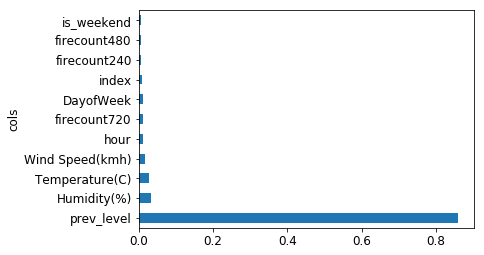

In [581]:
#Calculate feature of importance
fi_per = feat_importance(exported_pipeline, X_trn, y_trn, mean_squared_error)
# normalize feature of importance
fi_per['imp'] = fi_per['imp']/fi_per['imp'].sum()
fi_per.plot('cols', 'imp', 'barh', legend=False)